# Delve re-import helper

- Looks like it was imported originally with a threshold of 1_000_000. but this is resulting in really small partitions.
- Trying this time with 2_000_000

In [4]:
import hats_import

hats_import.__version__

'0.7.0'

In [5]:
import hats
from hats.pixel_math import HealpixPixel
import os

### Change this path!!!
catalog_dir = "/epyc/data3/hats/catalogs/delve/delve_dr2/"

### ----------------
### You probably won't have to change anything from here.

catalog = hats.read_hats(catalog_dir)

info_frame = catalog.partition_info.as_dataframe()

for index, partition in info_frame.iterrows():
    file_name = result = hats.io.paths.pixel_catalog_file(
        catalog_dir, HealpixPixel(partition["Norder"], partition["Npix"])
    )
    info_frame.loc[index, "size_on_disk"] = os.path.getsize(file_name)

info_frame = info_frame.astype(int)
info_frame["gbs"] = info_frame["size_on_disk"] / (1024 * 1024 * 1024)

In [6]:
print(f'healpix orders: {info_frame["Norder"].unique()}')
print(f'num partitions: {len(info_frame["Npix"])}')
print("------")
print(f'min size_on_disk: {info_frame["gbs"].min():.2f}')
print(f'max size_on_disk: {info_frame["gbs"].max():.2f}')
print(f'size_on_disk ratio: {info_frame["gbs"].max()/info_frame["gbs"].min():.2f}')
print(f'total size_on_disk: {info_frame["gbs"].sum():.2f}')

healpix orders: [1 2 3 4 5 6 7]
num partitions: 5513
------
min size_on_disk: 0.00
max size_on_disk: 0.34
size_on_disk ratio: 6449.25
total size_on_disk: 834.85


small-ish 	: 5513 	(100.0 %)
sweet-spot 	: 0 	(0.0 %)
big-ish 	: 0 	(0.0 %)
too-big 	: 0 	(0.0 %)


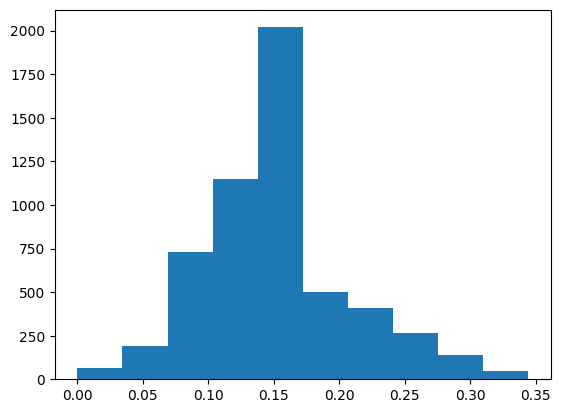

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(info_frame["gbs"])

bins = [0, 0.5, 1, 2, 100]
labels = ["small-ish", "sweet-spot", "big-ish", "too-big"]
hist = np.histogram(info_frame["gbs"], bins=bins)[0]
pcts = hist / len(info_frame)
for i in range(0, len(labels)):
    print(f"{labels[i]} \t: {hist[i]} \t({pcts[i]*100:.1f} %)")

In [12]:
catalog.catalog_info

catalog_name delve_dr2
catalog_type object
total_rows   2500247752
ra_column    RA
dec_column   DEC
npix_suffix  .parquet

In [10]:
stats = catalog.per_pixel_statistics(include_columns=["QUICK_OBJECT_ID"], include_stats=["row_count"])
stats.sort_values(["QUICK_OBJECT_ID: row_count"], ascending=False).head(5)

,QUICK_OBJECT_ID: row_count
"Order: 4, Pixel: 2062",999086
"Order: 6, Pixel: 33113",998755
"Order: 4, Pixel: 1962",998216
"Order: 5, Pixel: 10724",997110
"Order: 4, Pixel: 2786",996608


In [11]:
import os
import pyarrow.parquet as pq

sample_parquet_file = "/epyc/data3/hats/catalogs/delve/delve_dr2/dataset/Norder=4/Dir=0/Npix=2062.parquet"

sample_file_size = os.path.getsize(sample_parquet_file)
parquet_file = pq.ParquetFile(sample_parquet_file)
num_rows = parquet_file.metadata.num_rows

## 300MB
ideal_file_small = 300 * 1024 * 1024
## 1G
ideal_file_large = 1024 * 1024 * 1024

threshold_small = ideal_file_small / sample_file_size * num_rows
threshold_large = ideal_file_large / sample_file_size * num_rows

print(f"threshold between {int(threshold_small):_} and {int(threshold_large):_}")

threshold between 901_368 and 3_076_671
